In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# PARAMETERS
PATH = "/content/drive/My Drive/brain_ct/PATIENT"
RAW_PATH = PATH + "/rawIMG"
IN_PATH = PATH + "/inputIMG"
OUT_PATH = PATH + "/outputIMG"
ATTEMPT_PATH = PATH + "/attempts"
RESULT_PATH = "/content/drive/My Drive/brain_ct/results"
GEN_PATH = "/content/drive/My Drive/brain_ct/generatedScan"
SCAN_PATH = "/content/drive/My Drive/brain_ct/scan_dataset"
ROOT = "/IMG-0001-" # format -> ROOT + INDEX -> IMG-0001-000X

slices = 240
epochs = 100

In [0]:
from PIL import Image
from PIL import ImageChops

import os

i = 1
count = 0
while i < (slices-1):
  count += 1
  # Make A & B filenames
  INDEX = "{:05n}".format(i)
  A_PATH = RAW_PATH + ROOT + INDEX

  i += 2
  INDEX = "{:05n}".format(i)
  B_PATH = RAW_PATH + ROOT + INDEX
  
  i -= 1
  OUT = Image.open(RAW_PATH + ROOT + "{:05n}".format(i) + ".jpg")
  OUT.save(OUT_PATH + "/" + "{:05n}".format(count) + ".jpg")
  print("Saved OUT at " + OUT_PATH + "/" + "{:05n}".format(count) + ".jpg")
  
  X_FILE = IN_PATH + "/" + "{:05n}".format(count)
  
  # Load A & B images
  A = Image.open(A_PATH + ".jpg")
  B = Image.open(B_PATH + ".jpg")
  
  # Generate A*B and save -> X
  X = ImageChops.multiply(A,B)
  X.save(X_FILE + ".jpg", "JPEG")
  print("Saved X at " + X_FILE)
  

In [0]:
imgurls = !ls -1 "{IN_PATH}" # Save input filenames

n = 100 # imgs it'll use
train_n = round(n * 0.80) # Train/Test 0.8/0.2

randurls = np.copy(imgurls)

np.random.seed(1234)
np.random.shuffle(randurls) # Input shuffle

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(n, len(tr_urls), len(ts_urls))

100 80 20


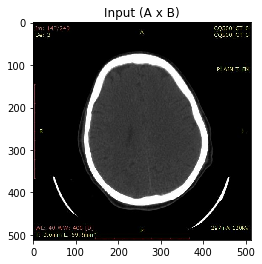

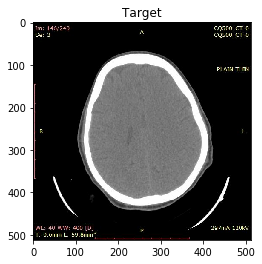

In [0]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

# Rescale images
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  
  return inimg, tgimg

# Normalize images
def normalize(inimg, tgimg):
  inimg = (inimg / 128) - 1
  tgimg = (tgimg / 128) - 1
  
  return inimg, tgimg

def load_image(filename):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(IN_PATH + "/" + filename)), tf.float32)[..., :3] # Float cast
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUT_PATH + "/" + filename)), tf.float32)[..., :3] # Float cast
  
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg, tgimg

plt.title("Input (A x B)")
plt.imshow((load_image(randurls[0])[0] + 1) / 2) #Input
plt.show()
plt.title("Target")
plt.imshow((load_image(randurls[0])[1] + 1) / 2) #Target

In [0]:
# Dataset Load
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # filename -> img
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # filename -> img
test_dataset = test_dataset.batch(1)

In [0]:
# ENCODER
# C64-C128-C256-C512-C512-C512-C512-C512

from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02) # mean 0 deviation 0.02
  
  # Convolutional layer
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2, # Each layer info shrinks by 1 / strides
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm)) # Only apply if not using BatchNorm
  
  if apply_batchnorm:
    # BatchNorm layer
    result.add(BatchNormalization())
  
  # Activation layer
  result.add(LeakyReLU())
  
  return result

downsample(64)

In [0]:
# DECODER
# CD512-CD512-CD512-C512-C256-C128-C64

def upsample(filters, apply_dropout=False):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02) # mean 0 deviation 0.02
  
  # Convolutional layer
  result.add(Conv2DTranspose(filters, #Conv2D inverse
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  
  # BatchNorm layer
  result.add(BatchNormalization())
  
  if apply_dropout:
    # Dropout layer (disconnects random connections, regularized)
    result.add(Dropout(0.5))
  
  # Activation layer
  result.add(ReLU())
  
  return result

upsample(64)

In [0]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None, None, 3]) # Not specified dimensions, 3 channels
  
  # C64-C128-C256-C512-C512-C512-C512-C512
  down_stack = [                        # (batch_size, width, height, filters)
      downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
      downsample(128),                       # (bs, 64, 64, 128)
      downsample(256),                       # (bs, 32, 32, 256)
      downsample(512),                       # (bs, 16, 16, 512)
      downsample(512),                       # (bs, 8, 8, 512)
      downsample(512),                       # (bs, 4, 4, 512)
      downsample(512),                       # (bs, 2, 2, 512)
      downsample(512),                       # (bs, 1, 1, 512)
  ]
  
  # CD512-CD512-CD512-C512-C256-C128-C64
  up_stack = [
      upsample(512, apply_dropout=True),     # (bs, 2, 2, 1024)
      upsample(512, apply_dropout=True),     # (bs, 4, 4, 1024)
      upsample(512, apply_dropout=True),     # (bs, 8, 8, 1024)
      upsample(512),                         # (bs, 16, 16, 1024)
      upsample(256),                         # (bs, 32, 32, 512)
      upsample(128),                         # (bs, 64, 64, 256)
      upsample(64),                          # (bs, 128, 128, 128)
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # Last layer = generated image
  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh" # de -1 a 1
                         )
  
  x = inputs
  
  s = [] # Skip Connections list
  
  concat = Concatenate()
  
  # Connect layers
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  s = reversed(s[:-1])
    
  for up, skip in zip(up_stack, s):
    
    x = up(x)
    x = concat([x, skip])
    
  last = last(x)
  
  return Model(inputs=inputs, outputs=last) # Builds model

generator = Generator()
generator

In [0]:
# DISCRIMINATOR 70x70
# C64-C128-C256-C512


def Discriminator():
  
  ini = Input(shape=[None, None, 3], name="input_img")
  gen = Input(shape=[None, None, 3], name="gener_img")
  
  con = concatenate([ini, gen])
  
  initializer = tf.random_normal_initializer(0, 0.2)
  
  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  last = tf.keras.layers.Conv2D(filters=1, # Pixel by pixel
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)
  
  return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()
discriminator

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Apply logit function

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  
  #gan_loss = adversary error
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  #mean absolute error, between generated and target
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss) #mas peso a l1_loss que al adversario
  return total_gen_loss

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(ATTEMPT_PATH + "/" + save_filename + ".jpg", prediction[0,...])
    
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ["Input image", "Ground Truth", "Predicted image"]
  
  if  display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis("off")
      
  plt.show()

In [0]:
@tf.function()
def train_step(input_image, target):
  
  # Gradients & Backpropagation
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
  
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)
    
    
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    
    imgi = 0
    for input_image, target in dataset:
      print("epoch " + str(epoch) + " - train: " + str(imgi) + "/" + str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)
    
    imgi = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + "_" + str(epoch), display_imgs=False)
      imgi += 1

In [0]:
def predict(model, index, input_img, save_filename=True):
  
  prediction = model(input_img, training=False)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(GEN_PATH + "/" + str(index) + ".jpg", prediction[0,...])

In [0]:
train(train_dataset, epochs)

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [0]:
def loadScanImage(filename):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(SCAN_PATH + "/" + filename)), tf.float32)[..., :3] # Float cast
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUT_PATH + "/" + filename)), tf.float32)[..., :3] # Float cast
  
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg

In [0]:
i = 1
count = 0

while i < slices:
  # Make A & B filenames
  INDEX = "{:05n}".format(i)
  A_PATH = RAW_PATH + ROOT + INDEX
  
  i += 1
  INDEX = "{:05n}".format(i)
  B_PATH = RAW_PATH + ROOT + INDEX
  
  X_FILE = SCAN_PATH + "/" + "{:05n}".format(count)
  count += 1
  
  # Load A & B images
  A = Image.open(A_PATH + ".jpg")
  B = Image.open(B_PATH + ".jpg")
  
  # Generate A*B and save -> X
  X = ImageChops.multiply(A,B)
  X.save(X_FILE + ".jpg", "JPEG")

scanurls = !ls -1 "{SCAN_PATH}"
scan_dataset = tf.data.Dataset.from_tensor_slices(scanurls)
scan_dataset = scan_dataset.map(loadScanImage, num_parallel_calls=tf.data.experimental.AUTOTUNE) # filename -> img
scan_dataset = scan_dataset.batch(1)

imgi = 1
for inp in scan_dataset:
  prediction = predict(generator, imgi, inp)
  imgi += 1

In [1]:
i = 1
count = 1

while i < slices:
  INDEX = "{:05n}".format(i)
  KNOWN_PATH = RAW_PATH + ROOT + INDEX
  PREDICTED_PATH = GEN_PATH + "/" + str(i)
  
  KNOWN = Image.open(KNOWN_PATH + ".jpg")
  PREDICTED = Image.open(PREDICTED_PATH + ".jpg")
  
  KNOWN.save(RESULT_PATH + "/" + ROOT + "{:05n}".format(str(count)) + ".jpg", "JPEG")
  PREDICTED.save(RESULT_PATH + "/" + ROOT + "{:05n}".format(str(count+1)) + ".jpg", "JPEG")
  
  i += 1
  count += 2

NameError: ignored